In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow.keras as tf
%matplotlib inline
warnings.filterwarnings('ignore')

In [16]:
ratings_df = pd.read_csv('data/ratings.csv')
ratings_df.head()
books_df = pd.read_csv('data/books.csv')
#books_df.head()

In [14]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [20]:
ratings_df.user_id.nunique()

53424

In [22]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


In [24]:
#Get the number of unique entities in books and users columns
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()

In [27]:
#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [30]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 15)        150015      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 15)        801375      input_6[0][0]                    
_______________________________________________________________________________________

In [36]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=10, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/10
12272/12272 [==============================] - 80s 6ms/step - loss: 0.3944 - val_loss: 0.8190
Epoch 2/10
12272/12272 [==============================] - 91s 7ms/step - loss: 0.3693 - val_loss: 0.8394
Epoch 3/10
12272/12272 [==============================] - 81s 7ms/step - loss: 0.3478 - val_loss: 0.8541
Epoch 4/10
12272/12272 [==============================] - 79s 6ms/step - loss: 0.3292 - val_loss: 0.8722
Epoch 5/10
12272/12272 [==============================] - 79s 6ms/step - loss: 0.3133 - val_loss: 0.8909
Epoch 6/10
12272/12272 [==============================] - 76s 6ms/step - loss: 0.2994 - val_loss: 0.9034
Epoch 7/10
12272/12272 [==============================] - 75s 6ms/step - loss: 0.2872 - val_loss: 0.9188
Epoch 8/10
12272/12272 [==============================] - 80s 7ms/step - loss: 0.2765 - val_loss: 0.9346
Epoch 9/10
12272/12272 [==============================] - 81s 7ms/step - loss: 0.2670 - val_loss: 0.9476
Epoch 10/10
12272/12272 [==============================

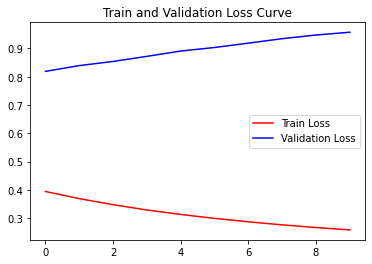

In [38]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [40]:
#save the model
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [43]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 15)        150015      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 15)        801375      input_6[0][0]                    
_______________________________________________________________________________________

In [46]:
# Extract embeddings
book_em = model.get_layer('embedding_4')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

In [49]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index("book_id")

In [51]:
b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)
dict_map = {}
for i in b_id:
    dict_map[i] = books_df_copy.iloc[i]['title']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
for i in b_id:
    book = dict_map[i]
    embeddings = book_em_weights[i]
    out_m.write(book + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()